# Basics of Mobile Robotics: Project

In [1]:
import time
from src import vision, pathfinder, navglobal, navlocal, thymio, draw, filtering, recording
import numpy as np

## 1. Setting up vision

In [2]:
source = vision.WebcamSource(builtin=True, recording='test.avi')
tools = vision.VisionTools()

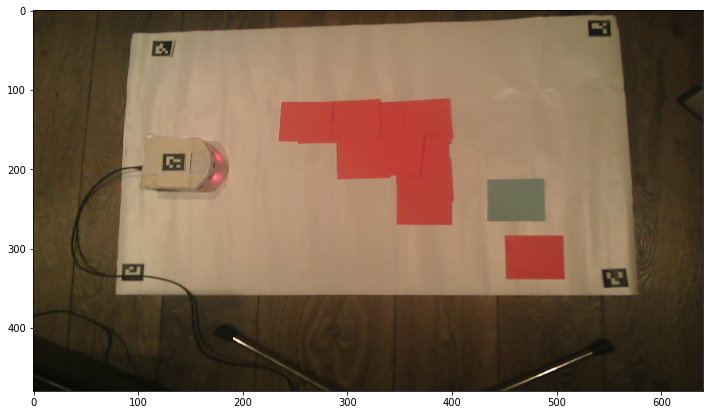

In [3]:
draw.plot_image(source.get_frame())

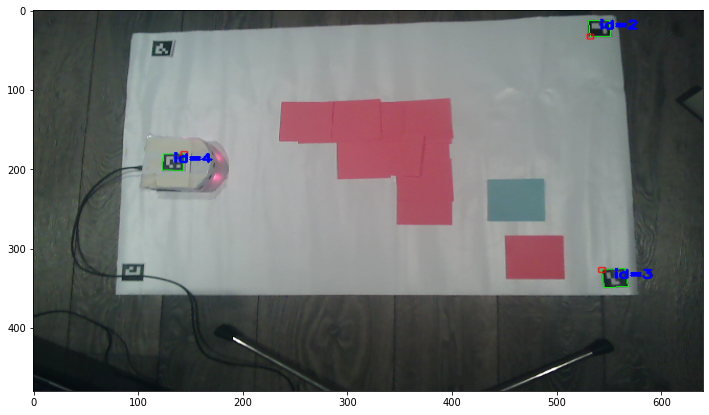

In [4]:
draw.display_aruco_markers(source, tools)

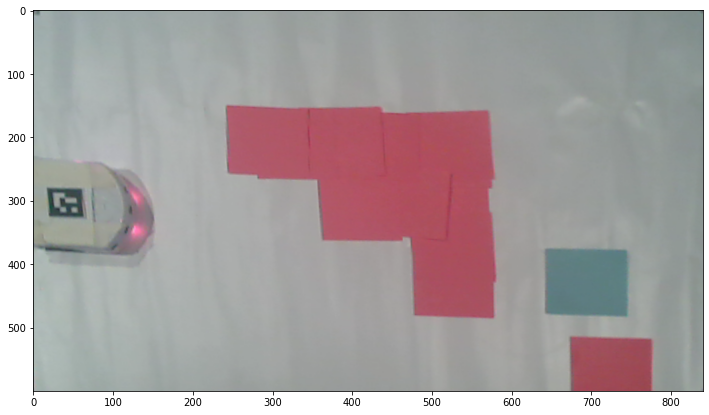

In [5]:
ready = False
while not ready:
    img = source.get_frame()
    corners_by_id = tools.get_aruco_dict(img)
    try:
        calibrated = tools.get_aruco_calibrated(img, corners_by_id)
        ready = True
    except:
        ready = False
draw.plot_image(calibrated)

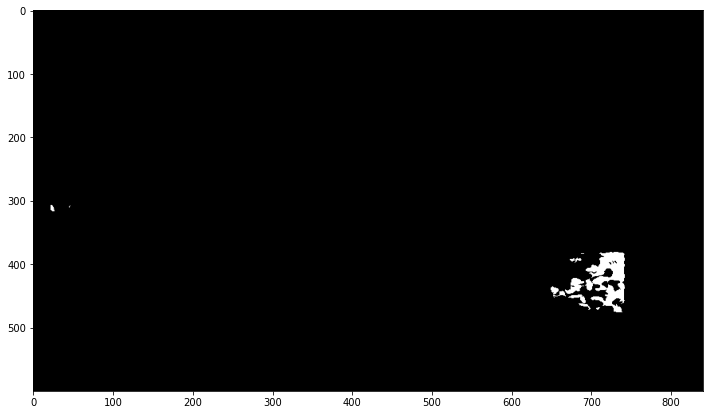

In [6]:
blue_bounds=vision.HSVBound(lb=np.array([80, 70, 0]), ub=np.array([170, 100, 140]))
mask = tools.get_color_mask(calibrated, blue_bounds)
draw.plot_image(mask)

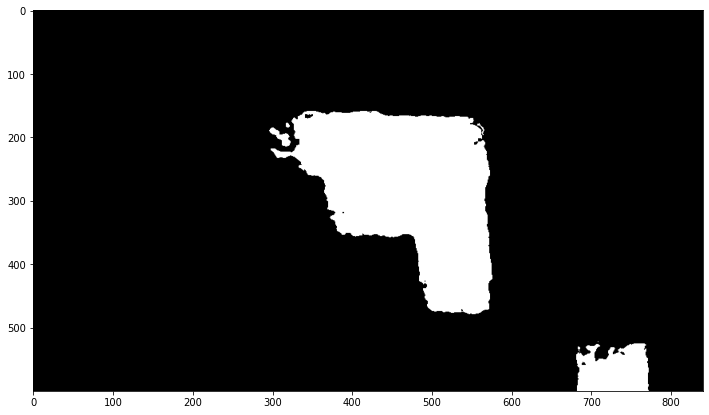

In [7]:
red_bounds=vision.HSVBound(lb=np.array([140, 130, 90]), ub=np.array([180, 255, 255]))
mask = tools.get_color_mask(calibrated, red_bounds)
draw.plot_image(mask)

In [8]:
pipeline = vision.VisionPipeline(source, tools=tools, red_bounds=red_bounds, blue_bounds=blue_bounds, dilate_factor=160)

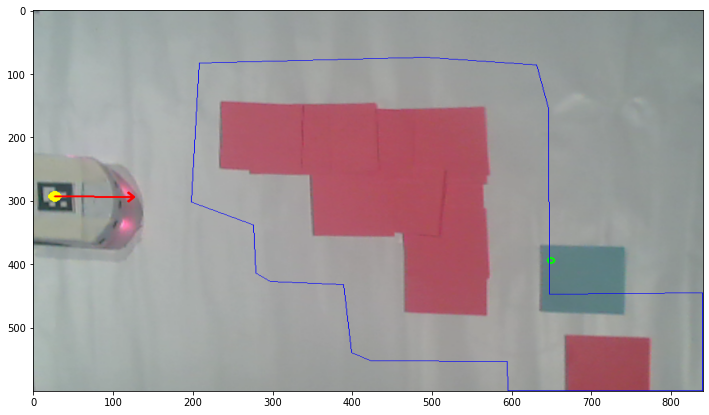

In [9]:
world = pipeline.analyze_scene()
result = pipeline.latest_frame.copy()
vision.draw_world(result, world)
draw.plot_image(result)

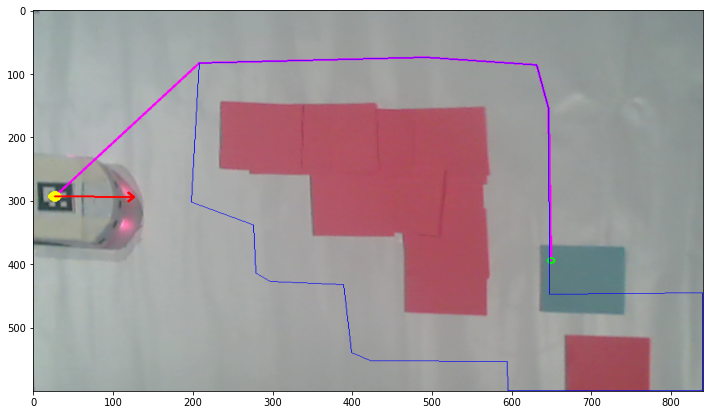

In [10]:
path = pathfinder.find_path(world)
result = pipeline.latest_frame.copy()
draw.draw_path(result, path)
vision.draw_world(result, world)
draw.plot_image(result)

## Recording

In [11]:
start = time.time()
pipeline.source.camera_thread.setup_recording()
recorder = recording.Recorder(pipeline, 'test.txt', start)
recorder.run(world, path)
pipeline.source.camera_thread.out = None

In [ ]:
from src import thymio
th = thymio.Thymio()
th.stop()

## Global Navigation

In [ ]:
#th = thymio.Thymio()

In [ ]:
# navigator = navglobal.GlobalNavigation(path)
# while not world.robot_at_goal(60):
#     world.robot = pipeline.get_robot_pose()
#     command = navigator.next_command(world.robot)
#     th.process_command(command)
# th.stop()

In [ ]:
# th.stop()

## Local Navigation

In [ ]:
th = thymio.Thymio()

In [ ]:
avoider = navlocal.LocalNavigation()
sensor_data = th.read_sensor_data()

while avoider.avoidance_mode(sensor_data):
    command = avoider.next_command(sensor_data)
    th.process_command(command)
    time.sleep(0.1)
    sensor_data = th.read_sensor_data()
th.stop()

In [ ]:
th.stop()

## Putting it together

In [ ]:
# Connect with the Thymio
th = thymio.Thymio()
# Setup global and local navigation object
navigator = navglobal.GlobalNavigation(path)
avoider = navlocal.LocalNavigation()
# Flag to check if we were in local avoidance
# This is used to recompute the path and update global navigation
was_in_avoidance = False
# Create the filter with initial state
kalman = filtering.Filter(world.robot)

# While we have not reached the goal
while not world.robot_at_goal(60):
    # Read data from the sensors
    sensor_data = th.read_sensor_data()

    # Check whether to use local or global navigation
    if avoider.avoidance_mode(sensor_data):
        command = avoider.next_command(sensor_data)
        was_in_avoidance = True
    else:
        # Recompute path if we left local avoidance
        if was_in_avoidance:
            path = pathfinder.find_path(world)
            navigator = navglobal.GlobalNavigation(path)
            was_in_avoidance = False
        command = navigator.next_command(world.robot)
    # Send the command to the Thymio
    th.process_command(command)
    # Read the pose from the camera
    pose = pipeline.get_robot_pose()
    # Update state with the filter
    world.robot = kalman.update_robot(pose, command, sensor_data, camera=pose is not None)
# Disconnect the Thymio
th.stop()

In [ ]:
th.stop()

In [ ]:
# sensor_data = th.read_sensor_data()
# while True:
#     navlocal.avoid_obstacle(th, pipeline.get_robot_pose)
# th.stop()
# print("Done")

In [ ]:
# kalman_filter = filtering.initialise(world.robot.position.v, world.robot.angle)

# while not world.robot_at_goal(50):
#     command = navglobal.follow_path(world.robot, path)
#     sensor_readings = th.read_sensor_data()
#     world.robot = pipeline.get_robot_pose()
#     filtering.update_robot(world.robot, command, sensor_readings, kalman_filter)
#     vision.draw_world(result, world)
#     draw.draw_path(result, path)
#     draw.plot_image(result)
#     # time.sleep(0.1)
# th.stop()

In [ ]:
th.stop()


## Final run sketch

The following sketches what the final run should look like combining every module together.

In [ ]:
# world = vision.analyze_scene()
# path = pathfinder.find_path(world)
# sensor_data = thymio.read_sensor_data()

# while not world.robot_at_goal():
#     if navlocal.sees_obstacle(sensor_data):
#         command = navlocal.avoid_obstacle(sensor_data)
#     else:
#         command = navglobal.follow_path(world.robot, world.goal, path)
#     thymio.process_command(command)
#     sensors = thymio.read_sensor_data()
#     filtering.update_robot(world.robot, command, sensors)
#     time.sleep(0.1)

# print("Completed!")